# Doing Bayesian Data Analysis

An example from __Chapter 18__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

from utils import plt, sns

In [2]:
df = pd.read_csv("../_data/Guber1999data.csv")
print len(df)
df.head()

50


,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [3]:
X = df[["Spend", "PrcntTake"]]
X["SpendXPrcnt"] = X.Spend * X.PrcntTake
y = df["SATT"]

# A little bit convoluted with the two columns
zx = ((X - X.mean().values) / X.std().values).values
zy = (y - y.mean()) / y.std()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
n_cols = 3
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)
    beta_1 = pm.Normal("beta_1", mu=0, tau=1E-8, shape=n_cols)
    theta = beta_0 + tt.dot(beta_1, zx.T)

    sigma = pm.HalfCauchy("sigma", 5)    # Gelman 2006
    nu = pm.Exponential("nu", 1.0 / 29)   # Taken from the book
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    trace = pm.sample(draws=6000, tune=1000, njobs=3, chain=3)
    
burn_in = 2000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -80.469: 100%|██████████| 200000/200000 [00:18<00:00, 10860.86it/s]
Finished [100%]: Average ELBO = -80.493
100%|██████████| 6000/6000 [00:17<00:00, 345.07it/s]


                mean         sd  mc_error   hpd_2.5   hpd_97.5
beta_0     -0.002056   0.061433  0.001013 -0.113392   0.123811
beta_1__0   0.022527   0.143275  0.005735 -0.262669   0.302938
beta_1__1  -1.520111   0.292953  0.013547 -2.095521  -0.930052
beta_1__2   0.647702   0.373464  0.017303 -0.121185   1.377287
sigma       0.415801   0.049608  0.000935  0.320737   0.512136
nu         34.087871  27.716833  0.495122  2.267266  88.034305


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c06c5d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119603190>]], dtype=object)

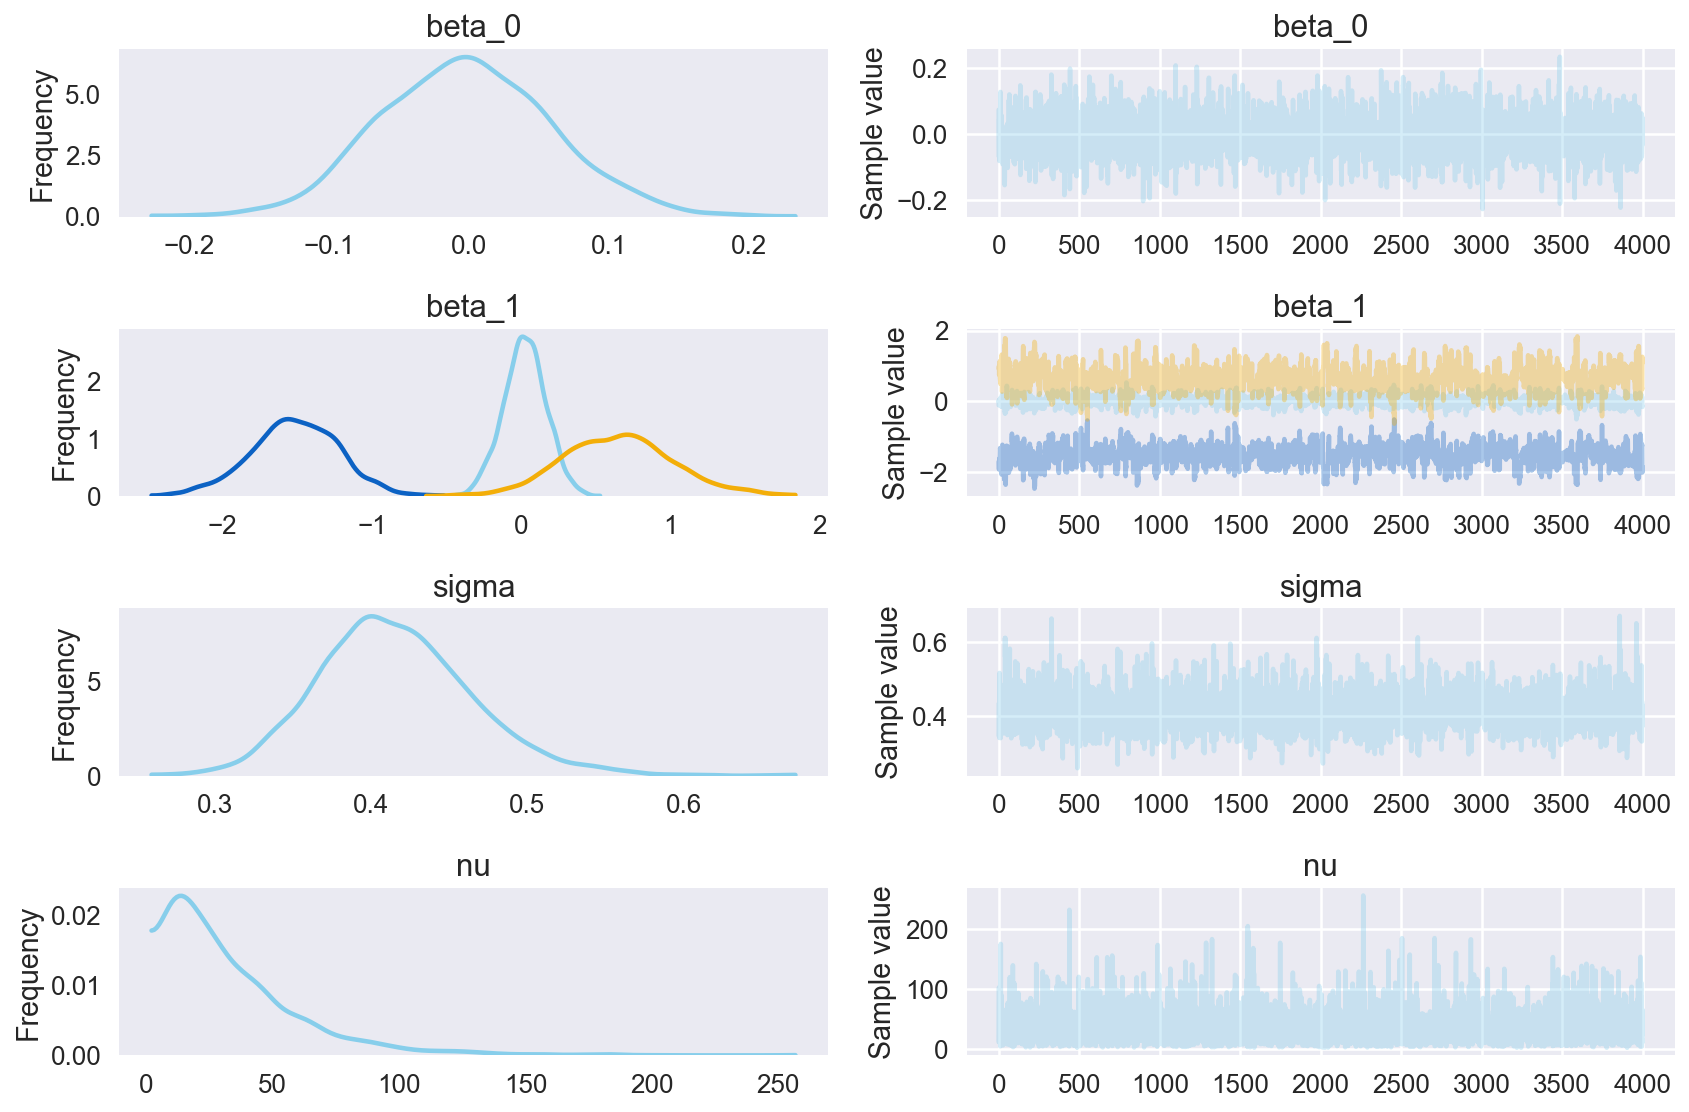

In [5]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1193a8110>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119e0fd10>], dtype=object)

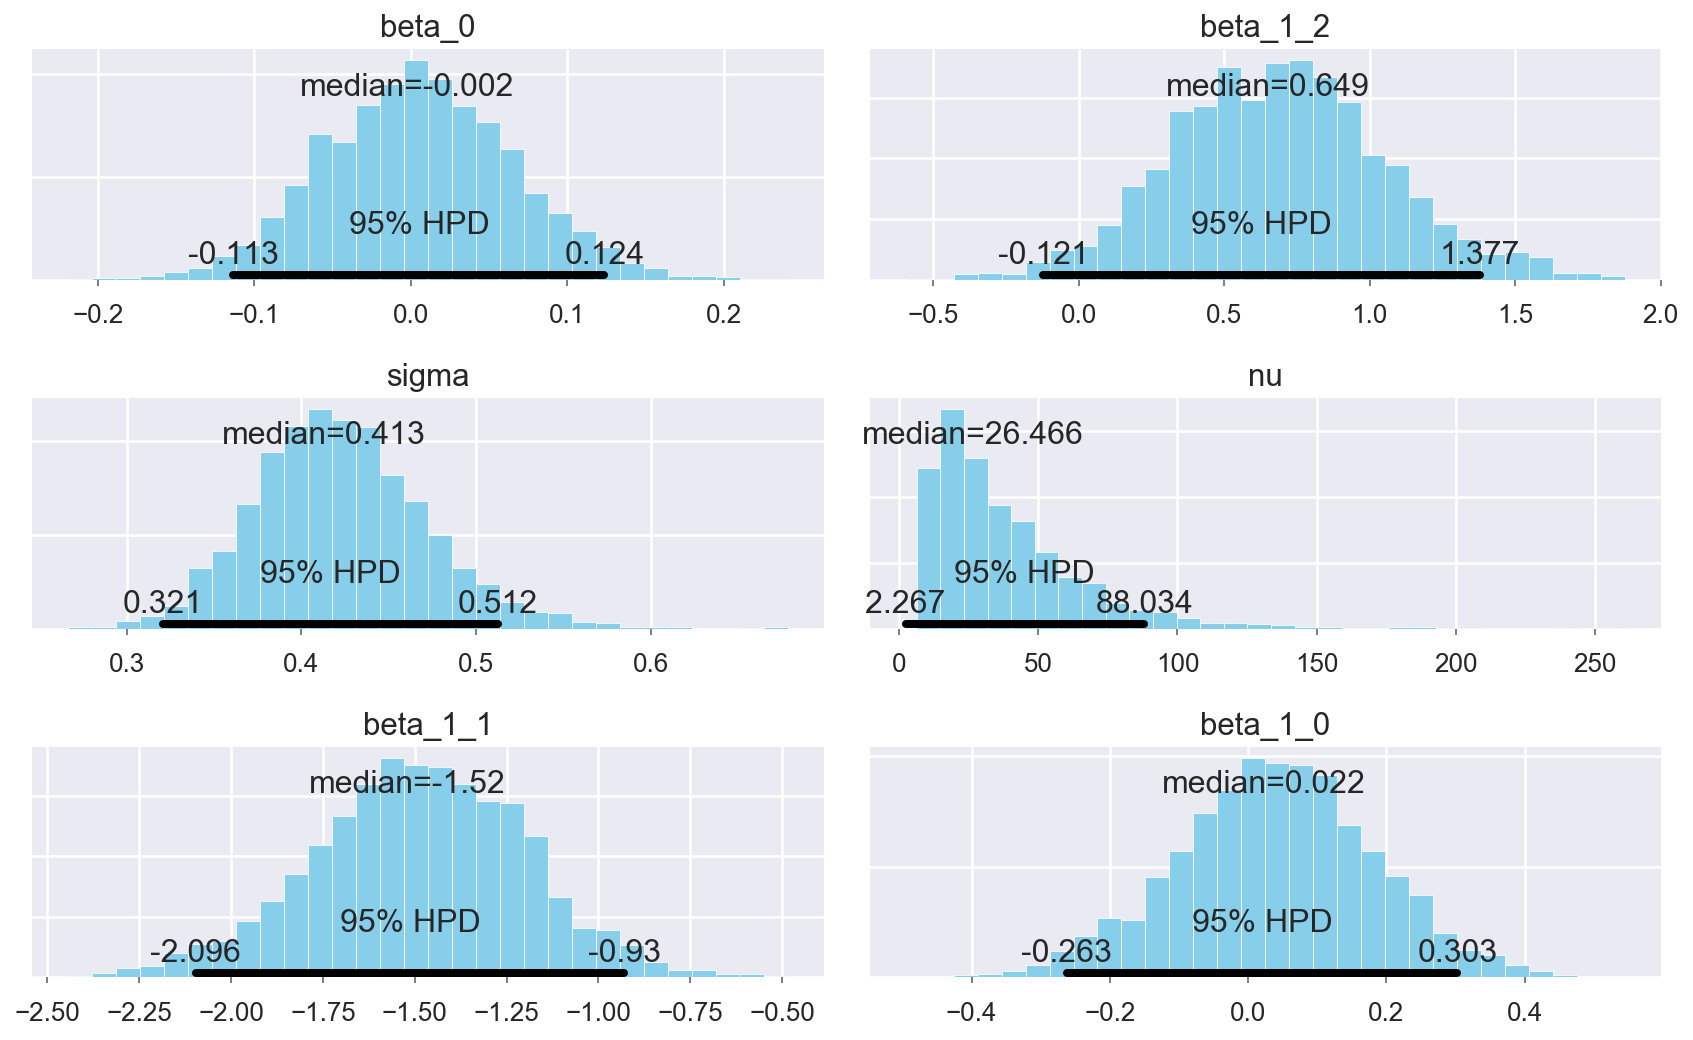

In [6]:
pm.plot_posterior(trace, point_estimate="median")

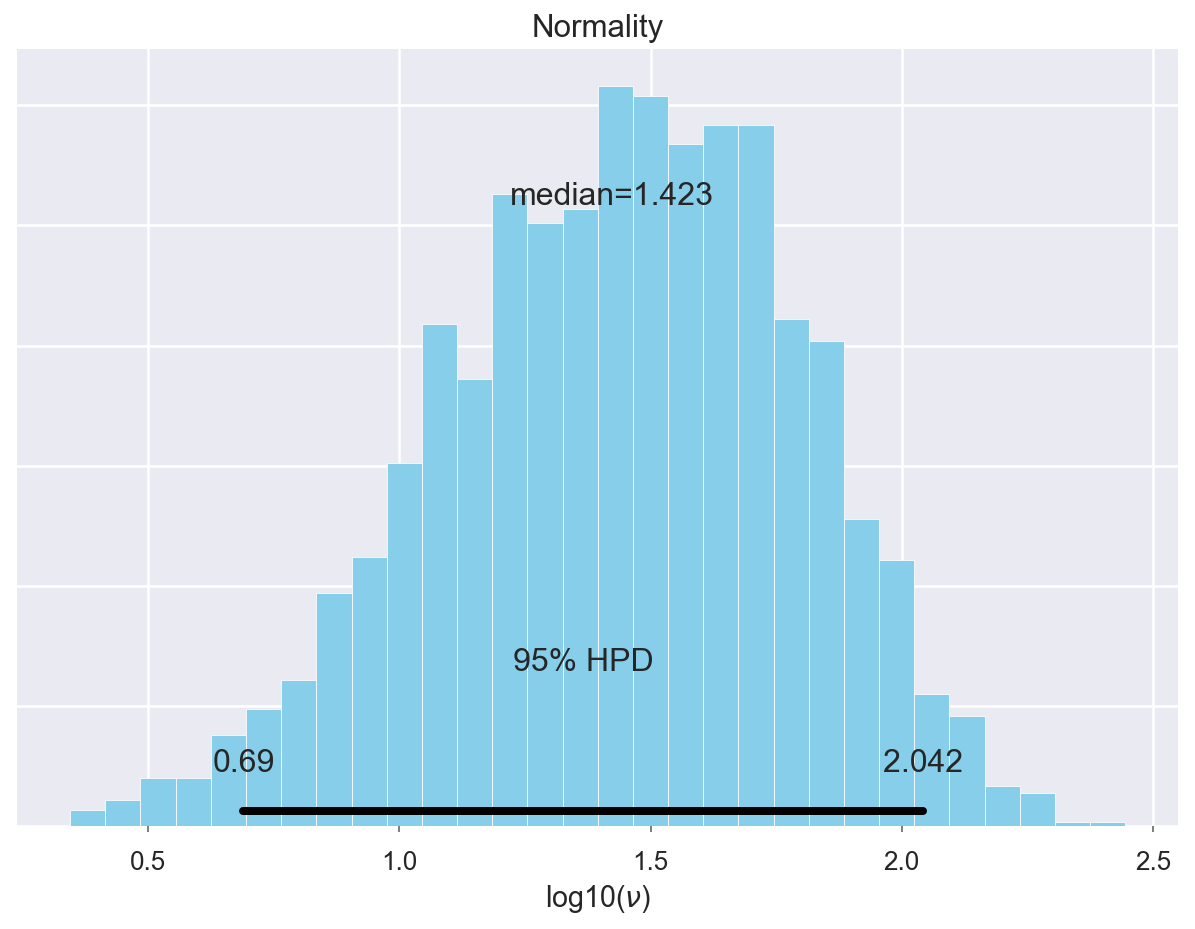

In [7]:
normality = np.log10(trace["nu"])
ax = pm.plot_posterior(normality, point_estimate="median")
ax.set_title("Normality")
ax.set_xlabel(r"log10($\nu$)")

In [ ]:
# PyMC's Rhat
pm.diagnostics.gelman_rubin(trace)